# Text classification (multi-label)
From tutorial: 
- https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
- https://kyawkhaung.medium.com/multi-label-text-classification-with-bert-using-pytorch-47011a7313b9

In [1]:
import os
import sys
import random
import warnings
warnings.filterwarnings("ignore")

#data manupulation libs
import pandas as pd
import numpy as np
import pickle
#from sklearn.model_selection import train_test_split

#from pandarallel import pandarallel

# Initialization
#pandarallel.initialize()

#string manupulation libs
#string manupulation libs
import re
import string
from string import digits
import spacy
import nltk
from nltk.corpus import stopwords 

#torch libs
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from datasets import Dataset, load_dataset, DatasetDict
import torch.nn as nn
import torch.optim as optim

import transformers

from transformers import AutoTokenizer, AutoModel, TrainingArguments

# data manipulations
from pathlib import Path
import uuid
import pydicom

from PIL import Image

import cv2
import matplotlib.pyplot as plt

import collections

from transformers import default_data_collator

In [2]:
# replace with the padded one
tokenizer = AutoTokenizer.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1")
model = AutoModel.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1") 

Some weights of the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 and are newly initialized: ['bert.poole

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 3090


### Remove all null labels 

In [5]:
df_train = pd.read_pickle('train.pkl')
df_test = pd.read_pickle('test.pkl')

print(type(df_train["diagnosis"][58646]))
print(df_train["diagnosis"][58646])
print(df_train.shape[0])

<class 'float'>
nan
222337


In [6]:
remove_rows_train = []
remove_rows_test = []

for i in range(df_train.shape[0]):
    if type(df_train["diagnosis"][i]) != list:
        remove_rows_train.append(i)
        
for i in range(df_test.shape[0]):
    if type(df_test["diagnosis"][i]) != list:
        remove_rows_test.append(i)

print(remove_rows_train)
print(remove_rows_test)

[34522, 58646, 98871, 128922, 137843, 140830, 169225, 207777]
[]


In [7]:
# nothing to be removed from df_test, only df_train
df_train = df_train.drop(remove_rows_train)
df_train = df_train.reset_index()
df_train = df_train.drop("index", 1)

df_test = df_test.reset_index()
df_test = df_test.drop("index", 1)

In [8]:
df_train.shape
display(df_train.head(n=df_train.shape[0]))

,study_id,raw_report,diagnosis
0,50414267,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,53189527,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,53911762,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,56699142,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,57375967,FINAL REPORT ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
222324,58708861,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
222325,57132437,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
222326,55368167,FINAL REPORT ...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
222327,58621812,FINAL REPORT ...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [9]:
df_test.head()

,study_id,raw_report,diagnosis
0,50331901,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,55504914,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,50051329,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,51738740,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,53492798,FINAL REPORT ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [10]:
# load dataframes as datasets
tds = Dataset.from_pandas(df_train)
vds = Dataset.from_pandas(df_test)


# put both train and test set into one DatasetDict
reports_dataset = DatasetDict()

reports_dataset['train'] = tds
reports_dataset['test'] = vds

print(reports_dataset)

DatasetDict({
    train: Dataset({
        features: ['study_id', 'raw_report', 'diagnosis'],
        num_rows: 222329
    })
    test: Dataset({
        features: ['study_id', 'raw_report', 'diagnosis'],
        num_rows: 3269
    })
})


In [11]:
reports_dataset = reports_dataset.rename_column("diagnosis", "labels")
reports_dataset

DatasetDict({
    train: Dataset({
        features: ['study_id', 'raw_report', 'labels'],
        num_rows: 222329
    })
    test: Dataset({
        features: ['study_id', 'raw_report', 'labels'],
        num_rows: 3269
    })
})

### Tokenization and Padding
- same as before: returning input_ids, attention_mask, labels (which is the array [0, 1, 1, 0, 0] 

In [13]:
padsize = 128

In [14]:
def tokenize_function_padding(dataset):
    result = tokenizer(dataset["raw_report"])
    return result

# Use batched=True to activate fast multithreading!
tokenized_datasets = reports_dataset.map(
    tokenize_function_padding, batched=True, remove_columns=["raw_report", "study_id"])

tokenized_datasets

  0%|          | 0/223 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 222329
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3269
    })
})

In [15]:
def padding(dataset):
    
    num_items = len(dataset['input_ids']) # to get number of all items in train dataset

    while(len(dataset['input_ids']) < padsize):
        dataset['input_ids'].append(0)
        dataset['token_type_ids'].append(0)
        dataset['attention_mask'].append(0)
        
    return dataset

padded_dataset = tokenized_datasets.map(padding, batched=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [17]:
smaller_dataset = padded_dataset.filter(lambda example: len(example['input_ids'])<=padsize)

  0%|          | 0/223 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [18]:
padded_dataset = smaller_dataset

def check_function(dataset):

    lenReport = len(dataset['input_ids'])
    
    if (lenReport > padsize):
        print('yes')
    return dataset

padded_dataset.map(check_function, batched = False, remove_columns=["token_type_ids"])

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 148696
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1775
    })
})

In [19]:
print(type(padded_dataset["train"]["input_ids"][0]))
print(type(padded_dataset["train"]["attention_mask"][0]))
print(type(padded_dataset["train"]["labels"][0]))

<class 'list'>
<class 'list'>
<class 'list'>


In [20]:
print(len(padded_dataset["test"]["input_ids"]))

1775


In [21]:
# class customDataset(Dataset):
#     def __init__(self, dataset, types):
#         self.dataset = dataset[types]
    
#     def __len__(self):
#         return len(self.dataset["input_ids"])
    
#     def __getitem__(self, idx):
#         input_ids = self.dataset["input_ids"][idx]
#         attention_mask = self.dataset["attention_mask"][idx]
#         labels = self.dataset["labels"][idx]
        
#         return dict(
#             input_ids = torch.tensor(input_ids, dtype=torch.long), 
#             attention_mask = torch.tensor(attention_mask, dtype=torch.long), 
#             labels = torch.tensor(labels, dtype=torch.float)
#         )

In [22]:
# train_dataset = customDataset(padded_dataset, "train")
# eval_dataset = customDataset(padded_dataset, "test")

In [23]:
# # print(train_dataset[0]["input_ids"])
# # print(train_dataset[0]["input_ids"].size())
# # print(train_dataset[0]["attention_mask"])
# # print(train_dataset[0]["attention_mask"].size())
# print(len(train_dataset))
# print(len(eval_dataset))
# print(train_dataset[0]["labels"])

### Adding linear layer to BERTmodel

In [24]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = AutoModel.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1") 
#         self.dropout = torch.nn.Dropout(0.3) # dunno if this work, forget about it now
        self.classifier = torch.nn.Linear(768, 13) # 768 and 13 are fixed in our case
    
    def forward(self, input_ids, mask):
        _, pooled_output = self.bert(input_ids = input_ids, attention_mask = mask, return_dict = False) # dun need word_id and token_type_id I think
#         output = self.dropout(output)
        output = self.classifier(pooled_output)
        return output

model = BERTClass()

Some weights of the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 and are newly initialized: ['bert.poole

### Train with Accelerate
- Try to train it the same way as before, with a linear layer added to BERTmodel
- Define new evaluation score: BCEwithLogits
- Add labels into training

#### 1. Dataloaders

In [25]:
from transformers import default_data_collator
data_collator = default_data_collator

In [26]:
batch_size = 32

train_dataloader = DataLoader(
    padded_dataset["train"],
    #train_dataset, 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=default_data_collator,
)

# Use the default_data_collator from Transformers for the evaluation set
eval_dataloader = DataLoader(
    padded_dataset["test"], 
    #eval_dataset, 
    batch_size=batch_size, 
    collate_fn=default_data_collator,
)

In [27]:
# # not yet return as a tensor?
# for batch_idx, data in enumerate(train_dataloader):
#     for batch_idx in range(100, 300, 1):
#         print(batch_idx, " ", data["labels"])

In [28]:
print(len(train_dataloader))
print(len(eval_dataloader))

4647
56


#### 2. Train with Accelerate 

In [29]:
# Adam optimizer 
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [30]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, 
    optimizer, 
    train_dataloader, 
    eval_dataloader
)

In [31]:
# Learning rate scheduler:
from transformers import get_scheduler

num_train_epochs = 5 # change this later

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [32]:
######### Saving onto Huggingface hub ########### (Not saving onto it)
from huggingface_hub import get_full_repo_name

model_name = "CXR_BioClinicalBERT_Class"
repo_name = get_full_repo_name(model_name)
repo_name

'ICLbioengNLP/CXR_BioClinicalBERT_Class'

In [33]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

/media/SharedUsers/dlc19/home/codes/nlp-fineTuningBERT/TextClassification/CXR_BioClinicalBERT_Class is already a clone of https://huggingface.co/ICLbioengNLP/CXR_BioClinicalBERT_Class. Make sure you pull the latest changes with `repo.git_pull()`.


#### 4. Training Loop

In [34]:
# Loss function - BCEwithLogitsLoss
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [35]:
val_targets = []
val_outputs = []

In [36]:
import shutil

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    accelerator.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [37]:
model.to(device)

from tqdm.auto import tqdm
import math

progress_bar = tqdm(range(num_training_steps))

valid_loss_min = np.Inf  # initialize tracker for minimum validation loss
checkpoint_path = 'CXR_BioClinicalBERT_Class/current_checkpoint.pt'
best_model_path = 'CXR_BioClinicalBERT_Class/best_model.pt'


for epoch in range(num_train_epochs): 
    
    train_loss = 0
    valid_loss = 0
    
    # Training
    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    
    for batch_idx, data in enumerate(train_dataloader):
        # optional - see Accelerate documentation 
#         ids = data["input_ids"].to(device, dtype = torch.long)
#         mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.float)
        ids = data["input_ids"]
        mask = data['attention_mask']
#         targets = data['labels']
        
        if batch_idx%100==0:
            print(f'batch id: {batch_idx}, now fit into model')

        outputs = model(ids, mask)
        
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if batch_idx%100==0:
            print(f'batch id: {batch_idx}, now finish loss')
        
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    
    
    # Evaluation
    model.eval()
    losses = []
    
    with torch.no_grad():
        for batch_idx, data in enumerate(eval_dataloader):
#             ids = data["input_ids"].to(device, dtype = torch.long)
#             mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.float)
            ids = data["input_ids"]
            mask = data['attention_mask']
#             targets = data['labels']
            
            if batch_idx%100==0:
                print(f'batch id: {batch_idx}, now fit into model')
            
            outputs = model(ids, mask)

            loss = loss_fn(outputs, targets)
            losses.append(accelerator.gather(loss.repeat(batch_size)))
            
            if batch_idx%100==0:
                print(f'batch id: {batch_idx}, now finish loss')

            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    losses = torch.cat(losses)
    losses = losses[: len(padded_dataset["test"]["input_ids"])]
    
    print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
    
    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    
    checkpoint = {
        'epoch': epoch+1,
        'valid_loss_min': valid_loss,
        'state_dict': unwrapped_model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    # Save the model to best_model_path if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss
    
    print('############# Epoch {}  Done   #############\n'.format(epoch))
    
#     unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
#     if accelerator.is_main_process:
#         tokenizer.save_pretrained(output_dir)
#         repo.push_to_hub(
#             commit_message=f"Training in progress epoch {epoch}", blocking=False
#         )

  0%|          | 0/23235 [00:00<?, ?it/s]

############# Epoch 0: Training Start   #############
batch id: 0, now fit into model
batch id: 0, now finish loss
batch id: 100, now fit into model
batch id: 100, now finish loss
batch id: 200, now fit into model
batch id: 200, now finish loss
batch id: 300, now fit into model
batch id: 300, now finish loss
batch id: 400, now fit into model
batch id: 400, now finish loss
batch id: 500, now fit into model
batch id: 500, now finish loss
batch id: 600, now fit into model
batch id: 600, now finish loss
batch id: 700, now fit into model
batch id: 700, now finish loss
batch id: 800, now fit into model
batch id: 800, now finish loss
batch id: 900, now fit into model
batch id: 900, now finish loss
batch id: 1000, now fit into model
batch id: 1000, now finish loss
batch id: 1100, now fit into model
batch id: 1100, now finish loss
batch id: 1200, now fit into model
batch id: 1200, now finish loss
batch id: 1300, now fit into model
batch id: 1300, now finish loss
batch id: 1400, now fit into mod

### Evaluation metrics

In [38]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [39]:
from sklearn import metrics

accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9378028169014084
F1 Score (Micro) = 0.9787094446084702
F1 Score (Macro) = 0.9677243649449839


In [40]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [41]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2425
           1       0.98      0.99      0.99      1960
           2       0.97      0.95      0.96       475
           3       0.99      1.00      0.99      1660
           4       0.89      0.89      0.89       325
           5       0.99      1.00      0.99       220
           6       0.92      0.97      0.95       200
           7       0.98      0.99      0.99      2275
           8       0.98      0.99      0.99      2600
           9       0.96      1.00      0.98       185
          10       0.95      0.92      0.93       725
          11       0.98      0.96      0.97       130
          12       0.98      0.97      0.98      2065

   micro avg       0.98      0.98      0.98     15245
   macro avg       0.97      0.97      0.97     15245
weighted avg       0.98      0.98      0.98     15245
 samples avg       0.93      0.93      0.93     15245



In [42]:
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

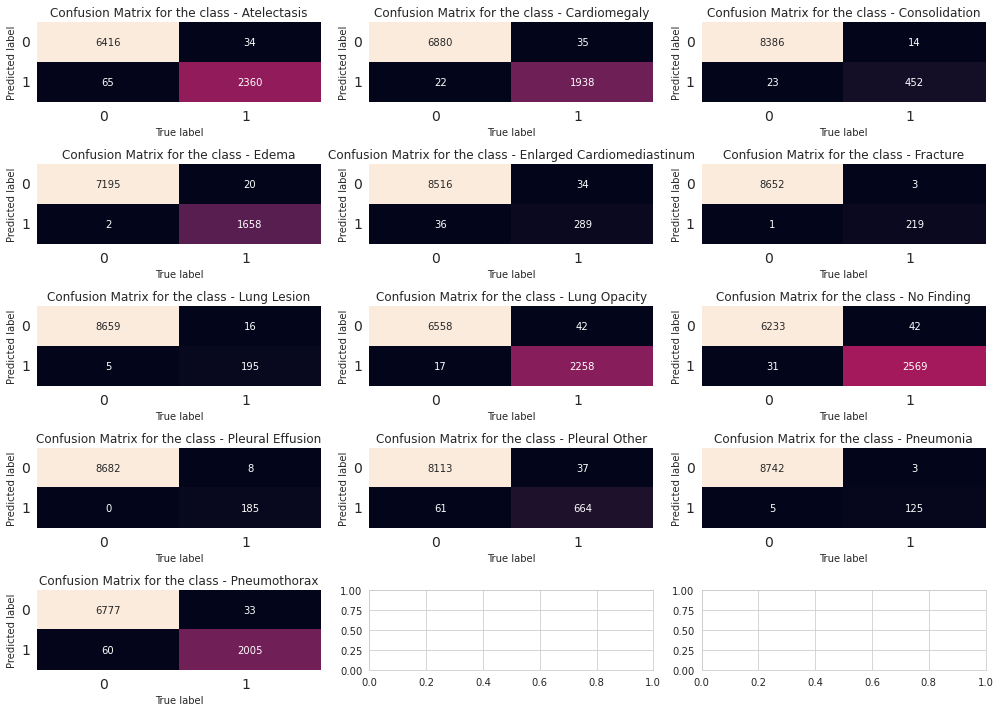

In [46]:
cm_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 
            'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax']
# OMG wrong order here... should be pleural effusion -> pneumothroax -> penumonia -> pleural other -> no findings
    
cm = mcm(val_targets, val_preds)

#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(5, 3, figsize=(14, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
    
fig.tight_layout()
plt.show()

### Prediction (without using pipeline) - load the trained model weights
- Just change and run this part for prediction

In [2]:
tokenizer = AutoTokenizer.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1")

In [3]:
class PredBERTClass(torch.nn.Module):
    def __init__(self):
        super(PredBERTClass, self).__init__()
        self.bert = AutoModel.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1") 
        self.dropout = torch.nn.Dropout(0.3) # dunno if this work, forget about it now
        self.classifier = torch.nn.Linear(768, 13) # 768 and 13 are fixed in our case
    
    def forward(self, input_ids, mask):
        _, pooled_output = self.bert(input_ids = input_ids, attention_mask = mask, return_dict = False) # dun need word_id and token_type_id I think
        output = self.dropout(pooled_output)
        output = self.classifier(output)
        output = torch.sigmoid(output)
        return output

In [6]:
from torch.optim import AdamW

trained_model = PredBERTClass()
trained_optimizer = AdamW(trained_model.parameters(), lr=5e-5)

best_model_path = 'CXR_BioClinicalBERT_Class/best_model.pt'

checkpoint = torch.load(best_model_path, map_location="cpu")
trained_model.load_state_dict(checkpoint['state_dict'])
trained_optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['valid_loss_min']

trained_model.eval()

Some weights of the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 and are newly initialized: ['bert.poole

PredBERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [7]:
targeted_index = 29   # from 0 to 164
section = "impression" # impression or findings

In [8]:
testing_df = pd.read_csv('final_samples.csv')
testing_df = testing_df.drop('Unnamed: 0', 1)
print(len(testing_df["study_id"].tolist()))

sample_dataset = dict.fromkeys(["study_id", "diagnosis", "diagnosis_id", "impression", "findings"])
sample_dataset["study_id"] = testing_df["study_id"].tolist()
sample_dataset["diagnosis"] = testing_df["diagnosis"].tolist()
sample_dataset["diagnosis_id"] = testing_df["diagnosis_id"].tolist()
sample_dataset["impression"] = testing_df["impression"].tolist()
sample_dataset["findings"] = testing_df["findings"].tolist()

164


In [9]:
targeted_id = sample_dataset["study_id"][targeted_index]
targeted_diag = sample_dataset["diagnosis"][targeted_index]
targeted_diag_id = sample_dataset["diagnosis_id"][targeted_index]
targeted_imp = sample_dataset["impression"][targeted_index]
targeted_find = sample_dataset["findings"][targeted_index]
print(targeted_diag)

Cardiomegaly


In [10]:
if section == "impression":
    report = targeted_imp

if section == "findings":
    report = targeted_find

# tokenize sentence and append to dictionary lists
new_tokens = tokenizer.encode_plus(report, max_length=128, truncation=True,
                                   padding='max_length', return_tensors='pt')
t_ids = new_tokens['input_ids']
t_mask = new_tokens['attention_mask']

In [11]:
print(t_ids)
print(t_mask)

tensor([[  101,  5199,  3621,  2660,  3263,  6997,  1183,  1110, 16684,   117,
          1175,  1110,  1185,  5048, 14494,  1137, 12104,  2229, 22832,  1785,
           119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [17]:
test_prediction = trained_model(t_ids, t_mask)
test_prediction = test_prediction.detach().numpy().tolist()
test_prediction = test_prediction[0]

In [18]:
print(type(test_prediction))
print(test_prediction)

<class 'list'>
[0.9997829794883728, 0.00030249429983086884, 4.767687278217636e-05, 0.00011366841499693692, 0.00011216091661481187, 4.856568921240978e-05, 0.00012035007966915146, 0.00017477165965829045, 0.00021956927957944572, 0.00018089056538883597, 0.00026254254044033587, 3.689595541800372e-05, 0.00025799681316129863]


In [19]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 
            'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax']

print("Targeted report has a diagnosis of >>> ", targeted_diag)
print(section, ":\n")
print(report)
print()

threshold = 0.5
for label, prediction in zip(labels, test_prediction):
#     if prediction < threshold:
#         continue
    print(label, " :", "%.5f"%prediction)

Targeted report has a diagnosis of >>>  Cardiomegaly
impression :

Severe cardiomegaly is unchanged, there is no edema or acute
 chest abnormality.

Atelectasis  : 0.99978
Cardiomegaly  : 0.00030
Consolidation  : 0.00005
Edema  : 0.00011
Enlarged Cardiomediastinum  : 0.00011
Fracture  : 0.00005
Lung Lesion  : 0.00012
Lung Opacity  : 0.00017
No Finding  : 0.00022
Pleural Effusion  : 0.00018
Pleural Other  : 0.00026
Pneumonia  : 0.00004
Pneumothorax  : 0.00026


In [409]:
for label, prediction in zip(labels, test_prediction):
    if prediction < threshold:
        continue
    print(label, " :", "%.5f"%prediction)

Atelectasis  : 0.99978


### (Not in use) Prediction - use Pipeline: zero-shot-classification
**Supports multi_label!**
- Source: https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681
- Source: https://huggingface.co/facebook/bart-large-mnli

In [16]:
# Example: 
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [17]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing', 'exploration']
classifier(sequence_to_classify, candidate_labels, multi_class=True)

The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


{'sequence': 'one day I will see the world',
 'labels': ['travel', 'exploration', 'dancing', 'cooking'],
 'scores': [0.9945111274719238,
  0.9383889436721802,
  0.005706179421395063,
  0.0018193130381405354]}

In [11]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1")

Some weights of the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at IC

In [14]:
sequence_to_classify = " FINAL REPORT EXAMINATION  CHEST PA AND LAT  INDICATION  F with new onset ascites   eval for infection  TECHNIQUE  Chest PA and lateral  COMPARISON  None  FINDINGS   There is no focal consolidation pleural effusion or pneumothorax  Bilateral nodular opacities that most likely represent nipple shadows The cardiomediastinal silhouette is normal  Clips project over the left lung potentially within the breast The imaged upper abdomen is unremarkable Chronic deformity of the posterior left sixth and seventh ribs are noted  IMPRESSION   No acute cardiopulmonary process"
candidate_labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other", "Pneumonia", "Pneumothorax"]
classifier(sequence_to_classify, candidate_labels, multi_label=True)

{'sequence': ' FINAL REPORT EXAMINATION  CHEST PA AND LAT  INDICATION  F with new onset ascites   eval for infection  TECHNIQUE  Chest PA and lateral  COMPARISON  None  FINDINGS   There is no focal consolidation pleural effusion or pneumothorax  Bilateral nodular opacities that most likely represent nipple shadows The cardiomediastinal silhouette is normal  Clips project over the left lung potentially within the breast The imaged upper abdomen is unremarkable Chronic deformity of the posterior left sixth and seventh ribs are noted  IMPRESSION   No acute cardiopulmonary process',
 'labels': ['No Finding',
  'Enlarged Cardiomediastinum',
  'Pneumothorax',
  'Atelectasis',
  'Pleural Effusion',
  'Edema',
  'Pleural Other',
  'Cardiomegaly',
  'Pneumonia',
  'Lung Opacity',
  'Lung Lesion',
  'Consolidation',
  'Fracture'],
 'scores': [0.447907954454422,
  0.4478684961795807,
  0.44755780696868896,
  0.4475393295288086,
  0.4475173354148865,
  0.4472104012966156,
  0.44697681069374084,
  